<a href="https://colab.research.google.com/github/nhuyen183/DS-DV-Project/blob/master/LungCancerDSS_preprocessing24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:1

# Create Spark entry points


In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [3]:
sc = SparkContext(conf=SparkConf())
spark = SparkSession(sparkContext=sc)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

# Step 1: Define the problem
What sorts of people were likely to have lung cancer?

# Step 2: Gather the data
The datasets can be found here: https://www.kaggle.com/datasets/aemreusta/brfss-2020-survey-data

# Step 3: Prepare data for consumption

In [5]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
! mkdir ~/.kaggle

In [7]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download aemreusta/brfss-2020-survey-data

 99% 48.0M/48.3M [00:03<00:00, 19.1MB/s]
100% 48.3M/48.3M [00:03<00:00, 14.7MB/s]


In [10]:
!ls

brfss-2020-survey-data.zip  spark-3.1.1-bin-hadoop3.2
drive			    spark-3.1.1-bin-hadoop3.2.tgz
sample_data


In [11]:
!unzip brfss-2020-survey-data.zip

Archive:  brfss-2020-survey-data.zip
  inflating: brfss2020.csv           


In [12]:
# load packages
import sys
print('Python version: {}'. format(sys.version))

import pandas as pd
print('Python version: {}'. format(pd.__version__))

import matplotlib
print('matplotlib version: {}'. format(matplotlib.__version__))

import numpy as np
print('numpy version: {}'. format(np.__version__))

import scipy as sp
print('scipy version: {}'. format(sp.__version__))

import IPython
from IPython import display # pretty printing of dataframe in Jupyter notebook
print('IPython version: {}'. format(IPython.__version__))

import pyspark
print('Apache Spark Pyspark version: {}'. format(pyspark.__version__)) # pyspark version

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
Python version: 1.3.5
matplotlib version: 3.2.2
numpy version: 1.21.6
scipy version: 1.7.3
IPython version: 7.9.0
Apache Spark Pyspark version: 3.1.1
-------------------------


In [13]:
from subprocess import check_output
print('-'*10, 'Files', '-'*10)
print(check_output(['ls', './']).decode('utf8'))

---------- Files ----------
brfss2020.csv
brfss-2020-survey-data.zip
drive
sample_data
spark-3.1.1-bin-hadoop3.2
spark-3.1.1-bin-hadoop3.2.tgz



# 
The Behavioral Risk Factor Surveillance System (BRFSS) is a collaborative project between all of the states in the United States and participating US territories and the Centers for Disease Control and Prevention (CDC).

BRFSS’s objective is to collect uniform state-specific data on health risk behaviors, chronic diseases and conditions, access to health care, and use of preventive health services related to the leading causes of death and disability in the United States. BRFSS conducts both landline and mobile phone-based surveys with individuals over the age of 18. General factors assessed by the BRFSS in 2020 included health status and healthy days, exercise, insufficient sleep, chronic health conditions, oral health, tobacco use, cancer screenings, and access to healthcare.

Survey data has been published annually by the CDC since 1984. You can find the original dataset as a ASCII format and past years data from here.

Survey data is shared by CDC in ASCII format. After converting the data to csv format, it was also published on Kaggle.

The aim of this project is to build a model with relatively high accuracy and AUC that could serve as an awareness-tool for those at high risk of developing heart disease.

The data contains information about 401958 unique survey participant. As a result of my research to select the ones related to coronary artery disease among a total of 279 different features, according to the information I got from the Texas Heart Institute website, there are 13 risk factors.

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest

In [ ]:
data_raw = spark.read.csv('./brfss2020.csv', inferSchema=True, header=True)

# the test file provided is for validation of final model.
#data_val = spark.read.csv('./kaggle-titanic-test.csv', inferSchema=True, header=True)

# preview the data
# data type
print('-'*10, 'data types', '-'*10)
pd.DataFrame(data_raw.dtypes)

---------- data types ----------


,0,1
0,_STATE,double
1,FMONTH,double
2,IDATE,int
3,IMONTH,int
4,IDAY,int
...,...,...
274,_STOLDNA,double
275,_VIRCOLN,double
276,_SBONTIM,double
277,_CRCREC1,double


In [ ]:
# data summary
print('-'*10, 'data summary', '-'*10)
data_raw.describe().toPandas()

---------- data summary ----------


,summary,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,...,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
0,count,401958,401958,401958,401958,401958,401958,401958,401958,401958,...,126604,177922,171486,171486,175853,176357,174274,194217,175698,367921
1,mean,30.010359291269236,5.959192253917076,6662701.046606859,6.510600610013982,15.008040641062001,2020.0301822578479,1117.7478741560064,2.0200045922818801E9,2.0200045922818801E9,...,2.3371615430792074,1.5802655096053326,2.851958760481905,2.8366630512111777,2.57898926944664,2.880906343383024,2.9384589783903508,2.5372959112745024,1.4172785119921685,2.040280386278576
2,stddev,15.773473494903223,3.5242238117738207,3462450.1811220297,3.4669000464972615,8.428138498040536,0.1710887546889567,38.207381620255546,3396.6841138105215,3396.6841138105215,...,2.2033784158573253,0.8728051431053163,0.44380827118133553,0.4879450778036646,0.6730066711378386,0.4513059766839771,0.32518874638973705,0.5119272764015419,0.7627272276885876,1.680522189372081
3,min,1.0,1.0,1012021,1,1,2020,1100.0,2020000001,2.020000001E9,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,max,72.0,12.0,12312020,12,31,2021,1200.0,2020015835,2.020015835E9,...,9.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0


In [ ]:
pd.DataFrame(data_raw.head())

,0
0,1.0
1,1.0
2,1042020.0
3,1.0
4,4.0
...,...
274,3.0
275,3.0
276,3.0
277,1.0


In [35]:
df = pd.read_csv('./brfss2020.csv')
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
0,1.0,1.0,1042020,1,4,2020,1100.0,2020000001,2.020000e+09,1.0,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0
1,1.0,1.0,2072020,2,7,2020,1200.0,2020000002,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2,1.0,1.0,1232020,1,23,2020,1100.0,2020000003,2.020000e+09,1.0,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0
3,1.0,1.0,1092020,1,9,2020,1100.0,2020000004,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1.0,1.0,1042020,1,4,2020,1100.0,2020000005,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0


In [18]:
# 401958 unique survey participant and a total of 279 different features
df.shape

(401958, 279)

In [36]:
#Question: Sex of Respondent
#Question: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]
#Question: Would you say that in general your health is:
#Question: Four-level smoker status: Everyday smoker, Someday smoker, Former smoker, Non-smoker
 #------Section Name: Lung Cancer Screening
#1Question: How old were you when you first started to smoke cigarettes regularly
#2Question: How old were you when you last smoked cigarettes regularly?
#3Question: On average, when you smoke/smoked regularly, about how many cigarettes do/did you usually smoke each day?
#4Question: In the last 12 months, did you have a CT or CAT scan?
#5Question: What type of cancer was it? (If Response = 2 (Two) or 3 (Three or more), ask: “With your most recent 
#diagnoses of cancer, what type of cancer was it?”) value=24 -> lung cancer

#Question: During the past 12 months, have you stopped smoking for one day or longer because you were trying to quit smoking? 
#Question: Have you ever used an e-cigarette or other electronic vaping product, even just one time, in your entire life?
#Question: Do you now use e-cigarettes or other electronic vaping products every day, some days, or not at all?
#Question: (Ever told) (you had) asthma?
df_selected = df[['SEXVAR', '_AGE65YR', '_BMI5CAT', 'GENHLTH', 'SMOKE100', '_SMOKER3',
                  'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'LCSCTSCN', 'CNCRTYP1',
                  'STOPSMK2', 'ECIGARET', 'ECIGNOW', 'ASTHMA3']]
df_selected.head()

,SEXVAR,_AGE65YR,_BMI5CAT,GENHLTH,SMOKE100,_SMOKER3,LCSFIRST,LCSLAST,LCSNUMCG,LCSCTSCN,CNCRTYP1,STOPSMK2,ECIGARET,ECIGNOW,ASTHMA3
0,2.0,1.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.0,1.0
1,2.0,2.0,3.0,3.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2.0,2.0,NaN,3.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0
3,2.0,2.0,NaN,1.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0
4,2.0,2.0,2.0,2.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0


In [25]:
df_selected.isnull().sum()

SEXVAR           0
_AGE65YR         0
_BMI5CAT     41357
GENHLTH          8
SMOKE100     17860
_SMOKER3         0
LCSFIRST    387914
LCSLAST     388332
LCSNUMCG    388351
LCSCTSCN    370711
CNCRTYP1    379282
STOPSMK2    349535
ECIGARET    137397
ECIGNOW     351208
ASTHMA3          3
dtype: int64

In [27]:
import seaborn as sns

**SEXVAR**

SEXVAR column contains participants gender information. 1 means male and 2 means female. For better reading, the column renamed as 'Gender'.

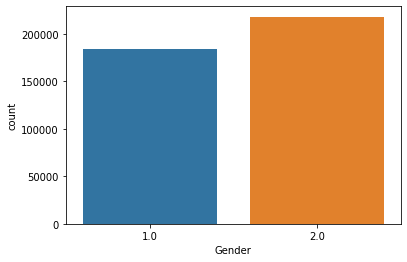

In [37]:
df_selected['SEXVAR'].value_counts()
df_selected = df_selected.rename(columns={"SEXVAR":"Gender"})
sns.countplot(x='Gender', data=df_selected)

**_AGE65YR**

The _AGE65YR column contains information about the age of the participants. Participants aged 65 and older are marked as 2, while younger ones are marked as 1. 3 means missing values and they removed.

For better reading, the column renamed as 'Over 65 Years Old'.

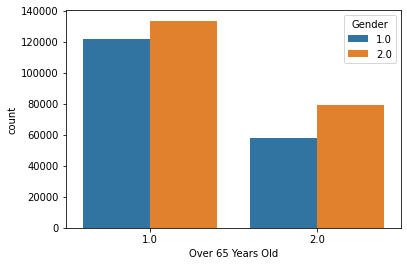

In [39]:
df_selected['_AGE65YR'].value_counts()
df_selected.drop(df_selected[df_selected['_AGE65YR'] == 3].index, inplace = True)
df_selected = df_selected.rename(columns={"_AGE65YR":"Over 65 Years Old"})
sns.countplot(x='Over 65 Years Old', hue='Gender', data=df_selected)

**GENHLTH**

The GENHLTH column contains participants general health information.

1 means excellent;
2 means very good;
3 means good;
4 means fair;
5 means poor;
7 and 9 means Don’t know/Not Sure/Refused

For better reading, the column renamed as 'General Health Status'. Uncertain values removed.

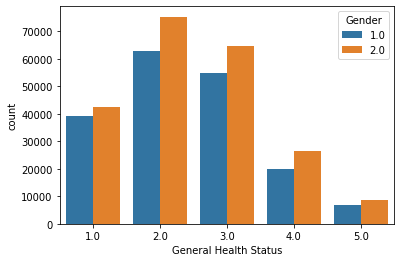

In [38]:
df_selected['GENHLTH'].value_counts()
df_selected = df_selected[(df_selected['GENHLTH'] != 7) & (df_selected['GENHLTH'] != 9)]
df_selected = df_selected.rename(columns={"GENHLTH":"General Health Status"})
sns.countplot(x='General Health Status', hue='Gender', data=df_selected)